In [33]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from lib.flows.elemwise import LogitTransform
from lib.plotting import get_grid, get_grid_corrector, get_grid_ode

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
eval_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
logit = LogitTransform(0.05)
reverse = logit.reverse

In [3]:
folder_path = 'save/sde-flow/default/mnist-True-True-64-0.0001-100000/'
gen_sde, optim, not_finished, count = torch.load(os.path.join(folder_path, 'checkpoint.pt'))

In [37]:
y0 = get_grid(gen_sde, 1, 28, 4, 1000, reverse)
y1 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-2)
y2 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=3e-3)
y3 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-3) # 似乎这个好
y4 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=3e-4)
y5 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-4)
y6 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=3e-5)
y7 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-5)

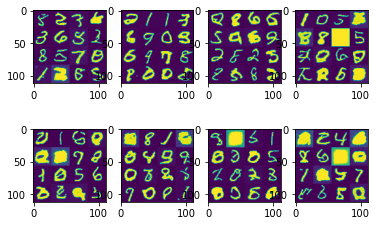

In [38]:

fig, axs = plt.subplots(2, 4)
axs[0][0].imshow(y0.squeeze())
axs[0][1].imshow(y1.squeeze())
axs[0][2].imshow(y2.squeeze())
axs[0][3].imshow(y3.squeeze())
axs[1][0].imshow(y4.squeeze())
axs[1][1].imshow(y5.squeeze())
axs[1][2].imshow(y6.squeeze())
axs[1][3].imshow(y7.squeeze())

In [43]:
save_dir = './save/img/corrector'
y0, ys = get_grid_corrector(gen_sde, input_channels=1, input_height=28, n=4, num_steps=1000, 
         transform=reverse, log_epoch=50, epsilon=3e-3)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for t in range(ys.shape[0]):
    file_name = os.path.join(save_dir, '{}.png'.format(t))
    y_view = ys[t].squeeze() * 255
    Image.fromarray(y_view).convert('RGB').save(file_name)

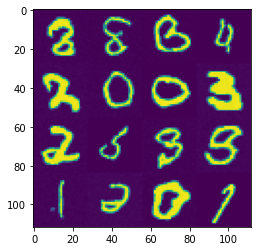

In [44]:
plt.imshow(ys[-1].squeeze())

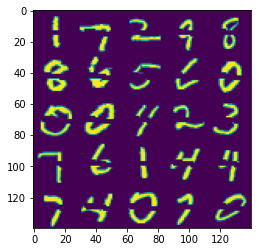

In [60]:
n = 5

mask = ~(train_dataset[8][0] > 0).transpose(-1, -2) # Mask: known pixels
mask.unsqueeze_(0)

data = []

for i in range(n*n):
    idx = np.random.randint(train_dataset.data.shape[0])
    data.append(train_dataset[idx][0]) 
data = torch.stack(data, dim=0)

data_view = (data*mask).view(
        n, n, 1, 28, 28).permute(
        2, 0, 3, 1, 4).contiguous().view(1, n * 28, n * 28)
plt.imshow(data_view.squeeze())

In [61]:
from lib.inpainting import inpaint
%load_ext autoreload
%autoreload 2
y0, ys = inpaint(gen_sde, data, mask, input_channels=1, input_height=data.shape[-1], num_steps=1000, 
         transform_forward=logit, transform_reverse=logit.reverse, log_epoch=50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(21, 25, 1, 28, 28)


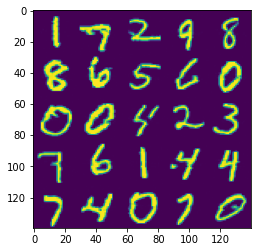

In [62]:
print(ys.shape)
y_view = ys[-1].reshape(
        (n, n, 1, 28, 28)).transpose(
        (2, 0, 3, 1, 4)).reshape((1, n * 28, n * 28))
plt.imshow(y_view.squeeze())

In [69]:
save_dir = './save/img/1'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for t in range(ys.shape[0]):
    file_name = os.path.join(save_dir, '{}.png'.format(t))
    y_view = ys[t].reshape((n, n, 1, 28, 28)).transpose((2, 0, 3, 1, 4)).reshape((n * 28, n * 28)) * 255
    Image.fromarray(y_view).convert('RGB').save(file_name)